In [3]:
import sys
sys.path.append("../")

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import torch
import torch.nn.functional as F
from torch_scatter import scatter_add

from src.bfsenv import State, BatchedState, GraphBuildingEnv, MolGraph
from src.models import GraphEmbedding, GraphPolicy, RewardModel
from src.random_graph import grid_graph, binomial_tree_graph

In [5]:

    

env = GraphBuildingEnv(1, 1, max_degree=4)


policy_nn = GraphPolicy(GraphEmbedding(env))
reward_nn = RewardModel(GraphEmbedding(env))

p_optim = torch.optim.Adam(
    policy_nn.parameters()
)
r_optim = torch.optim.Adam(
    reward_nn.parameters()
)

In [14]:
traj = env.state_to_trajectory(pos_x)

In [16]:
traj.get_last_state()

BatchedState(size_by_type: [0, 0, 0, 8])

In [ ]:
@torch.no_grad()
def sample_termial(model, size, max_step):
    model.eval()
    states = env.BatchedState([env.initial_state() for _ in range(size)])
    done_states = [None] * size

    for _ in range(max_step):
        fwd_dist = model.forward_action(states)
        actions = fwd_dist.sample()
        next_states = []
        for s, a in zip(states, actions):
            s_ = env.step(s, a)

            if s_.state_type == env.StateType.Terminal:
                done_states.add(s_)
            else:
                next_states.append(s_)

        states = env.BatchedState(next_states)
        if states.total_size == 0:
            break

    for s in states:
        s.terminate()
        done_states.add(s)
        
    return done_states

In [ ]:
class Sampler:
    def __init__(self, env, model, max_step):
        self.model = model


    @torch.no_grad()
    def sample_termial(model, size, max_step):
        model.eval()
        states = env.BatchedState([env.initial_state() for _ in range(size)])
        done_states = env.BatchedState()
    
        for _ in range(max_step):
            fwd_dist = model.forward_action(states)
            actions = fwd_dist.sample()
            next_states = []
            for s, a in zip(states, actions):
                s_ = env.step(s, a)
    
                if s_.state_type == env.StateType.Terminal:
                    done_states.add(s_)
                else:
                    next_states.append(s_)
    
            states = env.BatchedState(next_states)
            if states.total_size == 0:
                break
    
        for s in states:
            s.terminate()
            done_states.add(s)
            
        return done_states

    



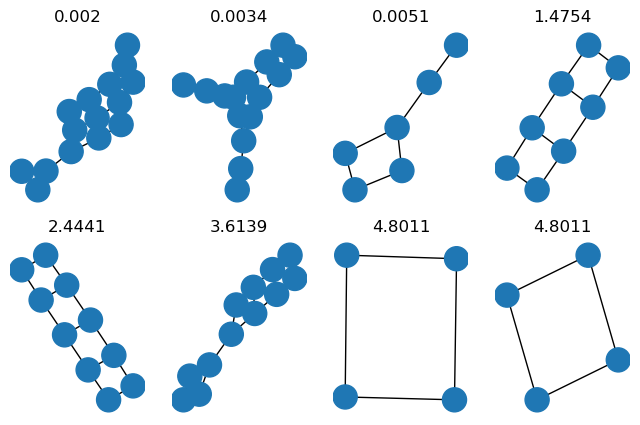

195


In [10]:
import tqdm
from IPython import display
from collections import defaultdict

size = 8
max_step = 40



losses = []
# pbar = tqdm.trange(1000)
pbar = range(200)
for i in pbar:
    # sampling
    neg_x = sample_termial(policy_nn, size, max_step)
    pos_x = grid_graph(size=size)
    
    pos_x.set_node_order(policy_nn.backward_action(pos_x).sample())

    with torch.no_grad():
        neg_logR = reward_nn(neg_x)
        pos_logR = reward_nn(pos_x)
        
    # update: GFN
    ploss = policy_nn.loss(neg_x, neg_logR).mean()
    dloss = policy_nn.loss(pos_x, pos_logR).mean()
    rloss = reward_nn.loss(pos_x, neg_x).mean()
    
    loss = ploss + dloss + rloss

    p_optim.zero_grad()
    r_optim.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_nn.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(reward_nn.parameters(), 1.0)
    p_optim.step()
    r_optim.step()
    
#     if i % 5 == 0:
        # update: energy
#         optimizer.zero_grad()
#         eloss.backward()
#         torch.nn.utils.clip_grad_norm_(energy.mlp.parameters(), 1.0)
#         optimizer.step()
        
    if i % 5 == 0:
        rank = torch.argsort(neg_logR)
        
        plt.figure(figsize=(8, 5))
        for k in range(8):
            r = rank[k].item()
            ax = plt.subplot(2, 4, k+1)
            plt.title(str(round(neg_logR[r].exp().item(), 4)))
            neg_x[r].visualize(figsize=None, ax=ax)
            plt.axis("off")
        plt.show()
        print(i)
        display.clear_output(wait=True)
        

    # logging
    loss_info = {
         "logR":neg_logR.mean().item(),
    }
#     pbar.set_postfix(loss_info)

    losses.append(loss_info)
    
history = pd.DataFrame(losses)

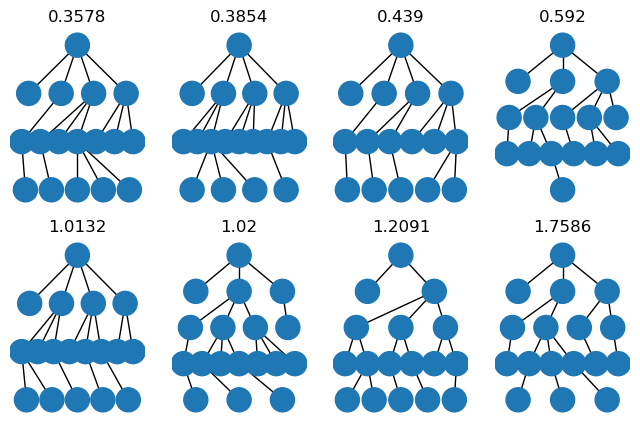

182


In [17]:
neg_x = sample_termial(model, size, max_step)
neg_logR = log_reward(neg_x)
rank = torch.argsort(neg_logR)

plt.figure(figsize=(8, 5))
for k in range(8):
    r = rank[k].item()
    ax = plt.subplot(2, 4, k+1)
    plt.title(str(round(neg_logR[r].exp().item(), 4)))
    neg_x[r].visualize(figsize=None, ax=ax, bfs_root=1)
    plt.axis("off")
plt.show()
print(i)

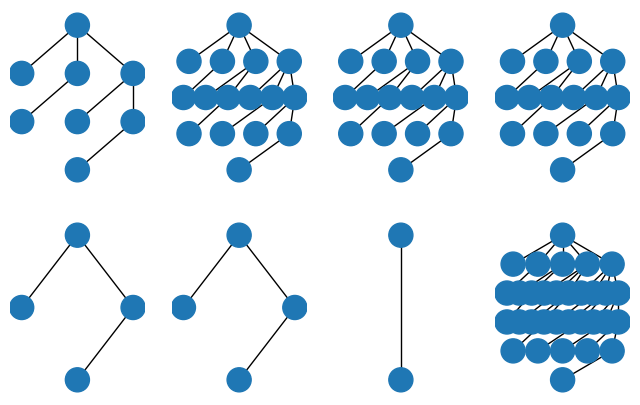

In [16]:
pos_logR = log_reward(pos_x)
rank = torch.argsort(pos_logR)

plt.figure(figsize=(8, 5))
for k in range(8):
    r = rank[k].item()
    ax = plt.subplot(2, 4, k+1)
    # plt.title(str(round(pos_logR[r].exp().item(), 4)))
    pos_x[r].visualize(figsize=None, ax=ax, bfs_root=0)
    plt.axis("off")
plt.show()